https://docs.pymc.io/notebooks/probabilistic_matrix_factorization.html


Probabilistic Matrix Factorization for Making Personalized Recommendations¶


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm

from matplotlib import pyplot as plt

plt.style.use("seaborn-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.2


In [ ]:
# data = pd.read_csv(pm.get_data('/content/drive/MyDrive/Movie/u.data'), sep="\t", names=["userid", "itemid", "rating", "timestamp"])
# data.head()

data =  pd.read_csv('/content/drive/MyDrive/Movie/u.data', sep="\t", names=["userid", "itemid", "rating", "timestamp"])
print(data)

       userid  itemid  rating  timestamp
0         196     242       3  881250949
1         186     302       3  891717742
2          22     377       1  878887116
3         244      51       2  880606923
4         166     346       1  886397596
...       ...     ...     ...        ...
99995     880     476       3  880175444
99996     716     204       5  879795543
99997     276    1090       1  874795795
99998      13     225       2  882399156
99999      12     203       3  879959583

[100000 rows x 4 columns]


In [ ]:
# fmt: off
movie_columns  = ['movie id', 'movie title', 'release date', 'video release date', 'IMDb URL',
                  'unknown','Action','Adventure', 'Animation',"Children's", 'Comedy', 'Crime',
                  'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                  'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
# fmt: on
movies = pd.read_csv(
    '/content/drive/MyDrive/Movie/u.item',
    sep="|",
    names=movie_columns,
    index_col="movie id",
    parse_dates=["release date"],encoding='latin-1'
)
movies.head()

,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie id,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


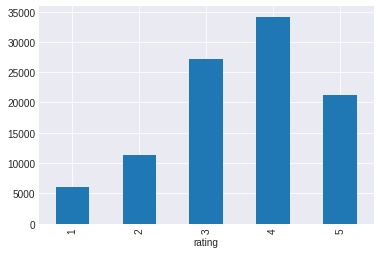

In [ ]:
# Extract the ratings from the DataFrame
ratings = data.rating

# Plot histogram
data.groupby("rating").size().plot(kind="bar");

In [ ]:
data.rating.describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

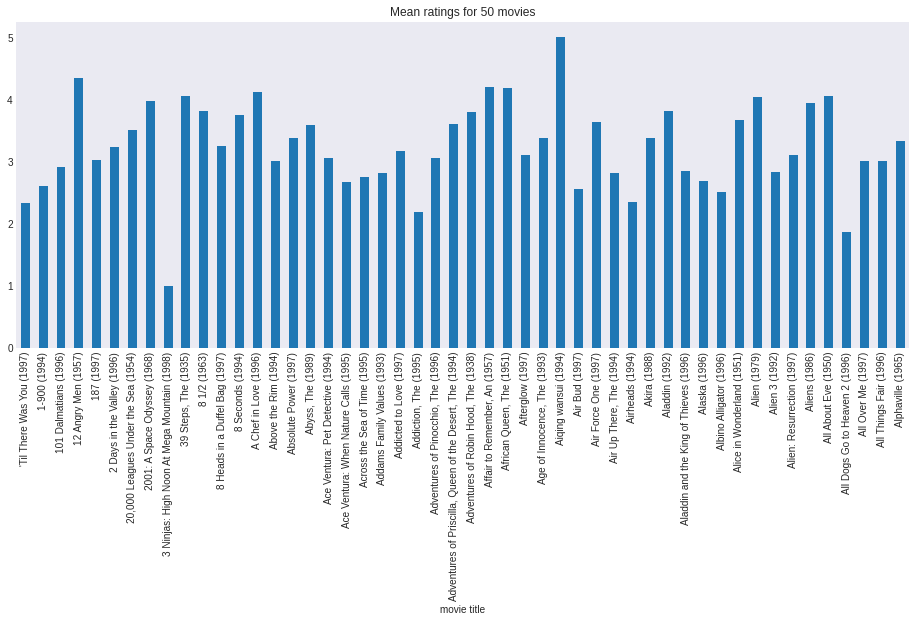

In [ ]:
movie_means = data.join(movies["movie title"], on="itemid").groupby("movie title").rating.mean()
movie_means[:50].plot(kind="bar", grid=False, figsize=(16, 6), title="Mean ratings for 50 movies");

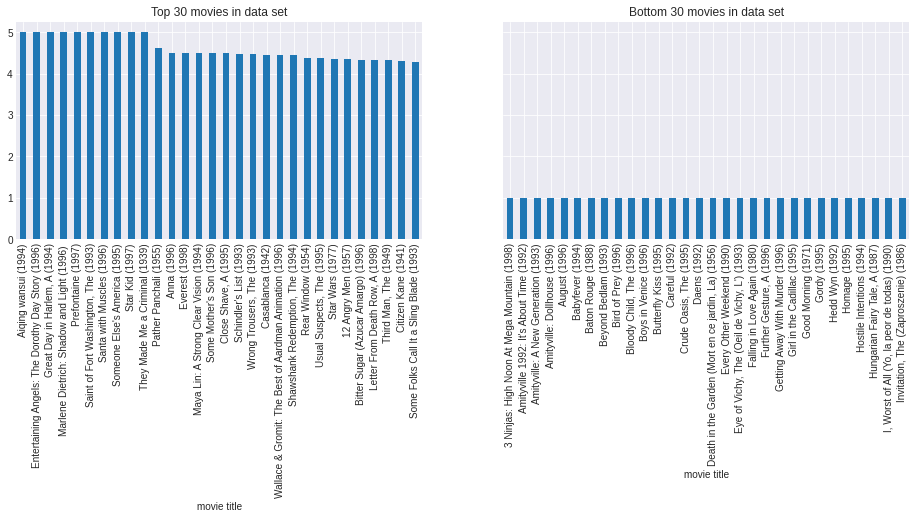

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 4), sharey=True)
movie_means.nlargest(30).plot(kind="bar", ax=ax1, title="Top 30 movies in data set")
movie_means.nsmallest(30).plot(kind="bar", ax=ax2, title="Bottom 30 movies in data set");

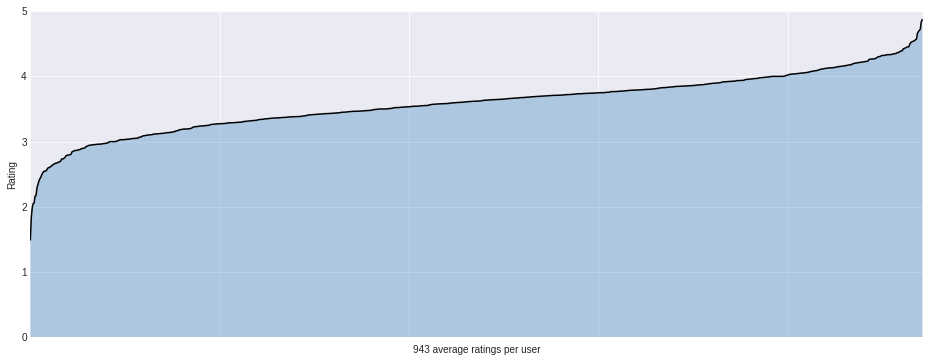

In [ ]:
user_means = data.groupby("userid").rating.mean().sort_values()
_, ax = plt.subplots(figsize=(16, 6))
ax.plot(np.arange(len(user_means)), user_means.values, "k-")

ax.fill_between(np.arange(len(user_means)), user_means.values, alpha=0.3)
ax.set_xticklabels("")
# 1000 labels is nonsensical
ax.set_ylabel("Rating")
ax.set_xlabel(f"{len(user_means)} average ratings per user")
ax.set_ylim(0, 5)
ax.set_xlim(0, len(user_means));

In [ ]:
# Create a base class with scaffolding for our 3 baselines.


def split_title(title):
    """Change "BaselineMethod" to "Baseline Method"."""
    words = []
    tmp = [title[0]]
    for c in title[1:]:
        if c.isupper():
            words.append("".join(tmp))
            tmp = [c]
        else:
            tmp.append(c)
    words.append("".join(tmp))
    return " ".join(words)


class Baseline:
    """Calculate baseline predictions."""

    def __init__(self, train_data):
        """Simple heuristic-based transductive learning to fill in missing
        values in data matrix."""
        self.predict(train_data.copy())

    def predict(self, train_data):
        raise NotImplementedError("baseline prediction not implemented for base class")

    def rmse(self, test_data):
        """Calculate root mean squared error for predictions on test data."""
        return rmse(test_data, self.predicted)

    def __str__(self):
        return split_title(self.__class__.__name__)


# Implement the 3 baselines.


class UniformRandomBaseline(Baseline):
    """Fill missing values with uniform random values."""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        masked_train = np.ma.masked_array(train_data, nan_mask)
        pmin, pmax = masked_train.min(), masked_train.max()
        N = nan_mask.sum()
        train_data[nan_mask] = np.random.uniform(pmin, pmax, N)
        self.predicted = train_data


class GlobalMeanBaseline(Baseline):
    """Fill in missing values using the global mean."""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        train_data[nan_mask] = train_data[~nan_mask].mean()
        self.predicted = train_data


class MeanOfMeansBaseline(Baseline):
    """Fill in missing values using mean of user/item/global means."""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        masked_train = np.ma.masked_array(train_data, nan_mask)
        global_mean = masked_train.mean()
        user_means = masked_train.mean(axis=1)
        item_means = masked_train.mean(axis=0)
        self.predicted = train_data.copy()
        n, m = train_data.shape
        for i in range(n):
            for j in range(m):
                if np.ma.isMA(item_means[j]):
                    self.predicted[i, j] = np.mean((global_mean, user_means[i]))
                else:
                    self.predicted[i, j] = np.mean((global_mean, user_means[i], item_means[j]))


baseline_methods = {}
baseline_methods["ur"] = UniformRandomBaseline
baseline_methods["gm"] = GlobalMeanBaseline
baseline_methods["mom"] = MeanOfMeansBaseline

In [ ]:
num_users = data.userid.unique().shape[0]
num_items = data.itemid.unique().shape[0]
sparsity = 1 - len(data) / (num_users * num_items)
print(f"Users: {num_users}\nMovies: {num_items}\nSparsity: {sparsity}")

dense_data = data.pivot(index="userid", columns="itemid", values="rating").values

Users: 943
Movies: 1682
Sparsity: 0.9369533063577546


In [ ]:
import logging
import time

import scipy as sp
import theano

# Enable on-the-fly graph computations, but ignore
# absence of intermediate test values.
theano.config.compute_test_value = "ignore"

# Set up logging.
logger = logging.getLogger()
logger.setLevel(logging.INFO)


class PMF:
    """Probabilistic Matrix Factorization model using pymc3."""

    def __init__(self, train, dim, alpha=2, std=0.01, bounds=(1, 5)):
        """Build the Probabilistic Matrix Factorization model using pymc3.

        :param np.ndarray train: The training data to use for learning the model.
        :param int dim: Dimensionality of the model; number of latent factors.
        :param int alpha: Fixed precision for the likelihood function.
        :param float std: Amount of noise to use for model initialization.
        :param (tuple of int) bounds: (lower, upper) bound of ratings.
            These bounds will simply be used to cap the estimates produced for R.

        """
        self.dim = dim
        self.alpha = alpha
        self.std = np.sqrt(1.0 / alpha)
        self.bounds = bounds
        self.data = train.copy()
        n, m = self.data.shape

        # Perform mean value imputation
        nan_mask = np.isnan(self.data)
        self.data[nan_mask] = self.data[~nan_mask].mean()

        # Low precision reflects uncertainty; prevents overfitting.
        # Set to the mean variance across users and items.
        self.alpha_u = 1 / self.data.var(axis=1).mean()
        self.alpha_v = 1 / self.data.var(axis=0).mean()

        # Specify the model.
        logging.info("building the PMF model")
        with pm.Model() as pmf:
            U = pm.MvNormal(
                "U",
                mu=0,
                tau=self.alpha_u * np.eye(dim),
                shape=(n, dim),
                testval=np.random.randn(n, dim) * std,
            )
            V = pm.MvNormal(
                "V",
                mu=0,
                tau=self.alpha_v * np.eye(dim),
                shape=(m, dim),
                testval=np.random.randn(m, dim) * std,
            )
            R = pm.Normal(
                "R", mu=(U @ V.T)[~nan_mask], tau=self.alpha, observed=self.data[~nan_mask]
            )

        logging.info("done building the PMF model")
        self.model = pmf

    def __str__(self):
        return self.name

In [ ]:
def _find_map(self):
    """Find mode of posterior using L-BFGS-B optimization."""
    tstart = time.time()
    with self.model:
        logging.info("finding PMF MAP using L-BFGS-B optimization...")
        self._map = pm.find_MAP(method="L-BFGS-B")

    elapsed = int(time.time() - tstart)
    logging.info("found PMF MAP in %d seconds" % elapsed)
    return self._map


def _map(self):
    try:
        return self._map
    except:
        return self.find_map()


# Update our class with the new MAP infrastructure.
PMF.find_map = _find_map
PMF.map = property(_map)

In [ ]:
# Draw MCMC samples.
def _draw_samples(self, **kwargs):
    kwargs.setdefault("chains", 1)
    with self.model:
        self.trace = pm.sample(**kwargs)


# Update our class with the sampling infrastructure.
PMF.draw_samples = _draw_samples

In [ ]:
def _predict(self, U, V):
    """Estimate R from the given values of U and V."""
    R = np.dot(U, V.T)
    n, m = R.shape
    sample_R = np.random.normal(R, self.std)
    # bound ratings
    low, high = self.bounds
    sample_R[sample_R < low] = low
    sample_R[sample_R > high] = high
    return sample_R


PMF.predict = _predict

In [ ]:
# Define our evaluation function.
def rmse(test_data, predicted):
    """Calculate root mean squared error.
    Ignoring missing values in the test data.
    """
    I = ~np.isnan(test_data)  # indicator for missing values
    N = I.sum()  # number of non-missing values
    sqerror = abs(test_data - predicted) ** 2  # squared error array
    mse = sqerror[I].sum() / N  # mean squared error
    return np.sqrt(mse)  # RMSE

In [ ]:
# Define a function for splitting train/test data.
def split_train_test(data, percent_test=0.1):
    """Split the data into train/test sets.
    :param int percent_test: Percentage of data to use for testing. Default 10.
    """
    n, m = data.shape  # # users, # movies
    N = n * m  # # cells in matrix

    # Prepare train/test ndarrays.
    train = data.copy()
    test = np.ones(data.shape) * np.nan

    # Draw random sample of training data to use for testing.
    tosample = np.where(~np.isnan(train))  # ignore nan values in data
    idx_pairs = list(zip(tosample[0], tosample[1]))  # tuples of row/col index pairs

    test_size = int(len(idx_pairs) * percent_test)  # use 10% of data as test set
    train_size = len(idx_pairs) - test_size  # and remainder for training

    indices = np.arange(len(idx_pairs))  # indices of index pairs
    sample = np.random.choice(indices, replace=False, size=test_size)

    # Transfer random sample from train set to test set.
    for idx in sample:
        idx_pair = idx_pairs[idx]
        test[idx_pair] = train[idx_pair]  # transfer to test set
        train[idx_pair] = np.nan  # remove from train set

    # Verify everything worked properly
    assert train_size == N - np.isnan(train).sum()
    assert test_size == N - np.isnan(test).sum()

    # Return train set and test set
    return train, test


train, test = split_train_test(dense_data)

In [ ]:
# Let's see the results:
baselines = {}
for name in baseline_methods:
    Method = baseline_methods[name]
    method = Method(train)
    baselines[name] = method.rmse(test)
    print("{} RMSE:\t{:.5f}".format(method, baselines[name]))

Uniform Random Baseline RMSE:	1.70090
Global Mean Baseline RMSE:	1.11846
Mean Of Means Baseline RMSE:	1.01127


In [ ]:
# We use a fixed precision for the likelihood.
# This reflects uncertainty in the dot product.
# We choose 2 in the footsteps Salakhutdinov
# Mnihof.
ALPHA = 2

# The dimensionality D; the number of latent factors.
# We can adjust this higher to try to capture more subtle
# characteristics of each movie. However, the higher it is,
# the more expensive our inference procedures will be.
# Specifically, we have D(N + M) latent variables. For our
# Movielens dataset, this means we have D(2625), so for 5
# dimensions, we are sampling 13125 latent variables.
DIM = 10


pmf = PMF(train, DIM, ALPHA, std=0.05)

INFO:root:building the PMF model
INFO:filelock:Lock 140267422347152 acquired on /root/.theano/compiledir_Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.7.11-64/.lock
INFO:filelock:Lock 140267422347152 released on /root/.theano/compiledir_Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.7.11-64/.lock
INFO:filelock:Lock 140267422992592 acquired on /root/.theano/compiledir_Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.7.11-64/.lock
INFO:filelock:Lock 140267422992592 released on /root/.theano/compiledir_Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.7.11-64/.lock
INFO:filelock:Lock 140267410296656 acquired on /root/.theano/compiledir_Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.7.11-64/.lock
INFO:filelock:Lock 140267410296656 released on /root/.theano/compiledir_Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.7.11-64/.lock
INFO:filelock:Lock 140267407371600 acquired on /root/.theano/compiledir_Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bio

In [ ]:
# Find MAP for PMF.
pmf.find_map();

INFO:root:finding PMF MAP using L-BFGS-B optimization...
INFO:filelock:Lock 140267196045840 acquired on /root/.theano/compiledir_Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.7.11-64/.lock
INFO:filelock:Lock 140267196045840 released on /root/.theano/compiledir_Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.7.11-64/.lock
INFO:filelock:Lock 140267196091216 acquired on /root/.theano/compiledir_Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.7.11-64/.lock
INFO:filelock:Lock 140267196091216 released on /root/.theano/compiledir_Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.7.11-64/.lock
INFO:filelock:Lock 140267195984784 acquired on /root/.theano/compiledir_Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.7.11-64/.lock
INFO:filelock:Lock 140267195984784 released on /root/.theano/compiledir_Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.7.11-64/.lock
INFO:filelock:Lock 140267221332880 acquired on /root/.theano/compiledir_Linux-5.4.104+-x86_

INFO:filelock:Lock 140266989223248 acquired on /root/.theano/compiledir_Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.7.11-64/.lock


INFO:filelock:Lock 140266989223248 released on /root/.theano/compiledir_Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.7.11-64/.lock
INFO:root:found PMF MAP in 76 seconds


In [ ]:
def eval_map(pmf_model, train, test):
    U = pmf_model.map["U"]
    V = pmf_model.map["V"]

    # Make predictions and calculate RMSE on train & test sets.
    predictions = pmf_model.predict(U, V)
    train_rmse = rmse(train, predictions)
    test_rmse = rmse(test, predictions)
    overfit = test_rmse - train_rmse

    # Print report.
    print("PMF MAP training RMSE: %.5f" % train_rmse)
    print("PMF MAP testing RMSE:  %.5f" % test_rmse)
    print("Train/test difference: %.5f" % overfit)

    return test_rmse


# Add eval function to PMF class.
PMF.eval_map = eval_map

In [ ]:
# Evaluate PMF MAP estimates.
pmf_map_rmse = pmf.eval_map(train, test)
pmf_improvement = baselines["mom"] - pmf_map_rmse
print("PMF MAP Improvement:   %.5f" % pmf_improvement)

PMF MAP training RMSE: 1.01581
PMF MAP testing RMSE:  1.14072
Train/test difference: 0.12492
PMF MAP Improvement:   -0.12946


In [ ]:
# Draw MCMC samples.
pmf.draw_samples(
    draws=20,
    tune=20,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  """
Only 20 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [V, U]
INFO:pymc3:NUTS: [V, U]


Sampling 1 chain for 20 tune and 20 draw iterations (20 + 20 draws total) took 668 seconds.
INFO:pymc3:Sampling 1 chain for 20 tune and 20 draw iterations (20 + 20 draws total) took 668 seconds.
INFO:filelock:Lock 140266993364560 acquired on /root/.theano/compiledir_Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.7.11-64/.lock
INFO:filelock:Lock 140266993364560 released on /root/.theano/compiledir_Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.7.11-64/.lock
/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:643: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


In [ ]:
def _norms(pmf_model, monitor=("U", "V"), ord="fro"):
    """Return norms of latent variables at each step in the
    sample trace. These can be used to monitor convergence
    of the sampler.
    """
    monitor = ("U", "V")
    norms = {var: [] for var in monitor}
    for sample in pmf_model.trace:
        for var in monitor:
            norms[var].append(np.linalg.norm(sample[var], ord))
    return norms


def _traceplot(pmf_model):
    """Plot Frobenius norms of U and V as a function of sample #."""
    trace_norms = pmf_model.norms()
    u_series = pd.Series(trace_norms["U"])
    v_series = pd.Series(trace_norms["V"])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    u_series.plot(kind="line", ax=ax1, grid=False, title=r"$\|U\|_{Fro}^2$ at Each Sample")
    v_series.plot(kind="line", ax=ax2, grid=False, title=r"$\|V\|_{Fro}^2$ at Each Sample")
    ax1.set_xlabel("Sample Number")
    ax2.set_xlabel("Sample Number")


PMF.norms = _norms
PMF.traceplot = _traceplot

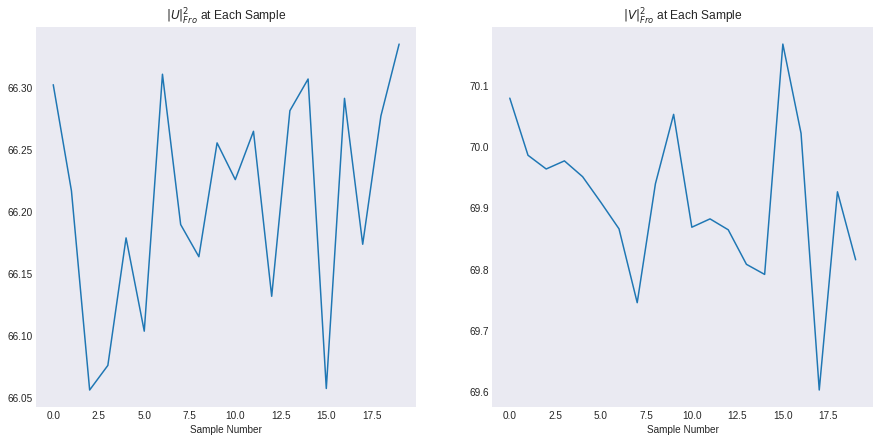

In [ ]:
pmf.traceplot()

In [ ]:
s without constraints, the solutions are at best symmetrical, at worse identical under any rotation, in any case subject to label switching. In fact if we sample from multiple chains we will see large r^ indicating the sampler is exploring different solutions in different part of parameter space.

def _running_rmse(pmf_model, test_data, train_data, burn_in=0, plot=True):
    """Calculate RMSE for each step of the trace to monitor convergence."""
    burn_in = burn_in if len(pmf_model.trace) >= burn_in else 0
    results = {"per-step-train": [], "running-train": [], "per-step-test": [], "running-test": []}
    R = np.zeros(test_data.shape)
    for cnt, sample in enumerate(pmf_model.trace[burn_in:]):
        sample_R = pmf_model.predict(sample["U"], sample["V"])
        R += sample_R
        running_R = R / (cnt + 1)
        results["per-step-train"].append(rmse(train_data, sample_R))
        results["running-train"].append(rmse(train_data, running_R))
        results["per-step-test"].append(rmse(test_data, sample_R))
        results["running-test"].append(rmse(test_data, running_R))

    results = pd.DataFrame(results)

    if plot:
        results.plot(
            kind="line",
            grid=False,
            figsize=(15, 7),
            title="Per-step and Running RMSE From Posterior Predictive",
        )

    # Return the final predictions, and the RMSE calculations
    return running_R, results


PMF.running_rmse = _running_rmse

predicted, results = pmf.running_rmse(test, train)

SyntaxError: ignored

In [ ]:
# And our final RMSE?
final_test_rmse = results["running-test"].values[-1]
final_train_rmse = results["running-train"].values[-1]
print("Posterior predictive train RMSE: %.5f" % final_train_rmse)
print("Posterior predictive test RMSE:  %.5f" % final_test_rmse)
print("Train/test difference:           %.5f" % (final_test_rmse - final_train_rmse))
print("Improvement from MAP:            %.5f" % (pmf_map_rmse - final_test_rmse))
print("Improvement from Mean of Means:  %.5f" % (baselines["mom"] - final_test_rmse))

In [ ]:
size = 100  # RMSE doesn't really change after 100th sample anyway.
all_results = pd.DataFrame(
    {
        "uniform random": np.repeat(baselines["ur"], size),
        "global means": np.repeat(baselines["gm"], size),
        "mean of means": np.repeat(baselines["mom"], size),
        "PMF MAP": np.repeat(pmf_map_rmse, size),
        "PMF MCMC": results["running-test"][:size],
    }
)
fig, ax = plt.subplots(figsize=(10, 5))
all_results.plot(kind="line", grid=False, ax=ax, title="RMSE for all methods")
ax.set_xlabel("Number of Samples")
ax.set_ylabel("RMSE");

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w